<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBC News Dataset

# Reading the Dataset and Creating the Dataframe

In [1]:
import pandas as pd

id_file = '1m41gWGwnLYo0nAEOABnU_MH_SCQHWfjS'
url_file = 'https://drive.google.com/uc?id={}'.format(id_file)

def create_dataframe(path):
    columns=['genre', 'filename', 'title', 'content']
    df =  pd.read_table(
    path,
    header=None,
    names=columns,
    sep= '\t',
    engine= 'python'
    )
    return df


df = create_dataframe(url_file)
df = df.drop(0).reset_index(drop=True)

df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [2]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import spacy
from spacy.lang.en.examples import sentences

!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Rename filenames

In [3]:
# In BBC dataset, some filenames have the same name, for example 001.txt, so it's necessary to rename
def rename_filenames(df):
  for index, row in df.iterrows():
      df.at[index, 'filename'] = f"{index}.txt"
  return df

df = rename_filenames(df)

## Create dataset with less samples

In [4]:
import random

# def create_balanced_small_df(df, genres, num):
#   small_df_list = []
#   for genre in genres:
#     sample_rows = df.sample(num)
#     small_df_list.append(sample_rows)
#   return pd.concat(small_df_list).reset_index(drop=True)

def create_imbalanced_small_df(df, genres, max_value):
  small_df_list = []
  for genre in genres:
    qtd = random.randint(5, max_value)
    # print(qtd)
    sample_rows = df[df['genre'] == genre].sample(qtd)
    small_df_list.append(sample_rows)
  return pd.concat(small_df_list).reset_index(drop=True)


In [5]:
genres = df['genre'].unique()
small_df = create_imbalanced_small_df(df, genres, max_value=20)
small_df

,genre,filename,title,content
0,business,138.txt,German jobless rate at new record,More than 5.2 million Germans were out of wor...
1,business,65.txt,German business confidence slides,German business confidence fell in February k...
2,business,232.txt,Bat spit drug firm goes to market,A German firm whose main product is derived f...
3,business,121.txt,US bank in $515m SEC settlement,Five Bank of America subsidiaries have agreed...
4,business,328.txt,House prices drop as sales slow,House prices fell further in November and pro...
...,...,...,...,...
61,tech,2164.txt,Sony PSP tipped as a 'must-have',Sony's Playstation Portable is the top UK gad...
62,tech,1928.txt,Nuclear body seeks new tech,The computer systems used to monitor the worl...
63,tech,2030.txt,How to smash a home computer,An executive who froze his broken hard disk t...
64,tech,2099.txt,EA to take on film and TV giants,Video game giant Electronic Arts (EA) says it...


# Pre Processing

In [6]:
def remove_non_alphanumeric(text):
    words = ''
    for w in text:
        words += w if w.isalnum() else ' '
    return words

def remove_accents(text):
  return unidecode.unidecode(text)


def lowercasting(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english')) #List of stop words in english
  tokens = [token for token in tokens if token not in stop_words]
  return tokens


def stemming(tokens):
  porter = PorterStemmer()
  tokens = [porter.stem(token) for token in tokens]
  return tokens


def lemmanization(text):
    nlp = spacy.load("en_core_web_sm")    # Load English language model
    doc = nlp(text)   # Process the text using the Spacy NLP
    tokens = [token.lemma_ for token in doc]
    return tokens


def pre_processing_aux(text):
  words = remove_non_alphanumeric(text)
  words = remove_accents(words)
  tokens = word_tokenize(words)
  tokens = lowercasting(tokens)
  tokens = remove_stop_words(tokens)
  words = ' '.join(tokens)
  tokens = lemmanization(words)
  tokens = stemming(tokens)
  return ' '.join(tokens)


In [7]:
def pre_processing(df):
    df['content'] = df['content'].apply(pre_processing_aux)
    return df

###########################################################
# To prossegue with all dataset, put df on parameter
# To prossegue with small dataset, put small_df in paramter
############################################################

df = pre_processing(small_df)
df.tail()

,genre,filename,title,content
61,tech,2164.txt,Sony PSP tipped as a 'must-have',soni playstat portabl top uk gadget 2005 accor...
62,tech,1928.txt,Nuclear body seeks new tech,comput system use monitor world nuclear power ...
63,tech,2030.txt,How to smash a home computer,execut freez break hard disk think would fix t...
64,tech,2099.txt,EA to take on film and TV giants,video game giant electron art ea say want beco...
65,tech,2040.txt,Cyber criminals step up the pace,call phish attack tri trick peopl hand confide...


# Basic statistics analysis

##Documents number by class

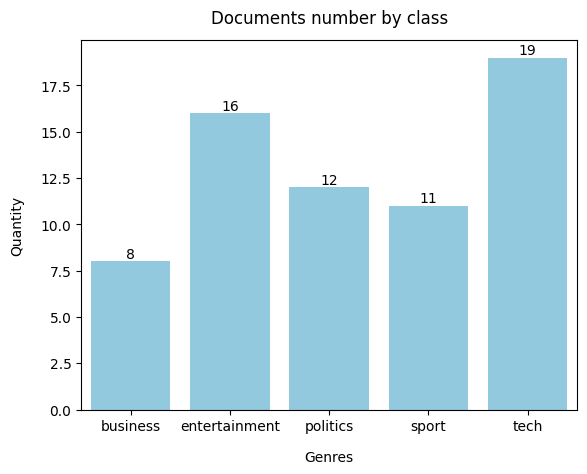

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

genres = df['genre'].unique()

def plot_doc_by_class(genres):
  ax = sns.countplot(x = 'genre', data = df , color='skyblue')
  ax.yaxis.grid(False)
  plt.title('Documents number by class', pad=12)
  plt.xlabel('Genres', labelpad=12)
  plt.ylabel('Quantity', labelpad=12)

  bars = ax.patches
  # Put numbers of docs above bars
  for bar in bars:
        height = int(bar.get_height())
        plt.text(bar.get_x() + bar.get_width()/2, height, height, ha='center', va='bottom')

  plt.show()


plot_doc_by_class(genres)

#Top 30 most frequent words

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

def get_genre_content(df, genre):
  content = df.loc[df['genre'] == genre, 'content'].str.cat(sep=' ')
  return content

def create_dict_content(df):
  dict_content = {}
  for genre in genres:
      dict_content[genre] = get_genre_content(df, genre)
      if 'all' in dict_content:
        dict_content['all'] += get_genre_content(df, genre)
      else:
          dict_content['all'] = get_genre_content(df, genre)
  return dict_content

def create_count_content(dict_content):
  count_content = {}
  for genre, content in dict_content.items():
      count_content[genre] = Counter(content.split())
  return count_content


def get_top_n_words(top_n, count_words):
    most_common_words = {}
    for word, count in count_words.most_common(top_n):
        most_common_words[word] = count
    return most_common_words


In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_h_most_common_words(top_n, count_content, genre, title, fontsize):
    most_common = get_top_n_words(top_n, count_content[genre])
    most_common = sorted(most_common.items(), key=lambda x: x[1])
    words = [item[0] for item in most_common ]
    counts = [item[1] for item in most_common ]
    plt.figure(figsize=(11, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Quantity', labelpad=15)
    plt.ylabel('Tokens', labelpad=15)
    plt.grid(False)
    plt.title(title, pad=15)
    #Display number of token in front of each bar
    for i in range(len(words)):
      plt.text(counts[i], i, ' ' + str(counts[i]), ha='left', va='center')

dict_content = create_dict_content(df)
count_content = create_count_content(dict_content)

In [11]:
print(count_content)

{'business': Counter({'say': 25, 'economi': 19, 'year': 18, 'rate': 16, 'price': 14, 'govern': 13, 'figur': 12, 'growth': 10, 'month': 10, 'm': 10, 'sec': 10, '5': 9, 'high': 9, 'market': 9, 'unemploy': 9, 'confid': 9, '2004': 9, 'rise': 9, 'time': 9, 'german': 8, 'also': 8, 'million': 7, 'work': 7, 'econom': 7, '2005': 7, 'take': 7, 'could': 7, 'fall': 7, 'sale': 7, 'fund': 7, '2': 6, 'new': 6, '4': 6, 'job': 6, 'look': 6, 'busi': 6, 'first': 6, 'three': 6, 'main': 6, 'last': 6, 'consum': 6, 'spend': 6, 'firm': 6, 'interest': 6, 'share': 6, 'industri': 6, 'columbia': 6, 'china': 6, 'februari': 5, 'show': 5, 'peopl': 5, 'come': 5, '1': 5, 'level': 5, 'still': 5, 'offici': 5, 'employ': 5, '9': 5, 'ifo': 5, 'bank': 5, 'economist': 5, 'domest': 5, 'trade': 5, 'demand': 5, 'make': 5, 'compani': 5, 'total': 5, 'part': 5, 'penalti': 5, 'give': 5, 'build': 5, 'south': 5, 'plan': 5, 'effect': 5, 'french': 5, 'germani': 4, 'would': 4, 'januari': 4, 'late': 4, 'set': 4, 'increas': 4, '000': 4, '

##Top 30 most frequent tokens in business

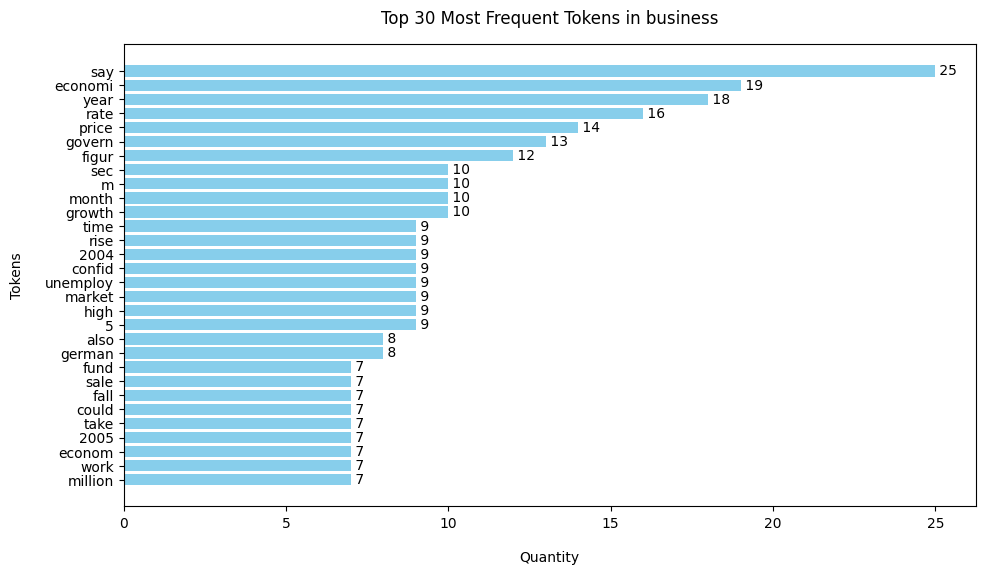

In [12]:
top_n = 30
fontsize = 12
title_business = 'Top {} Most Frequent Tokens in business'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'business', title_business, fontsize)
# common_words_business = get_top_n_words(top_n, count_content['business'])
# print(common_words_business)

##Top 30 most frequent tokens in entertainment




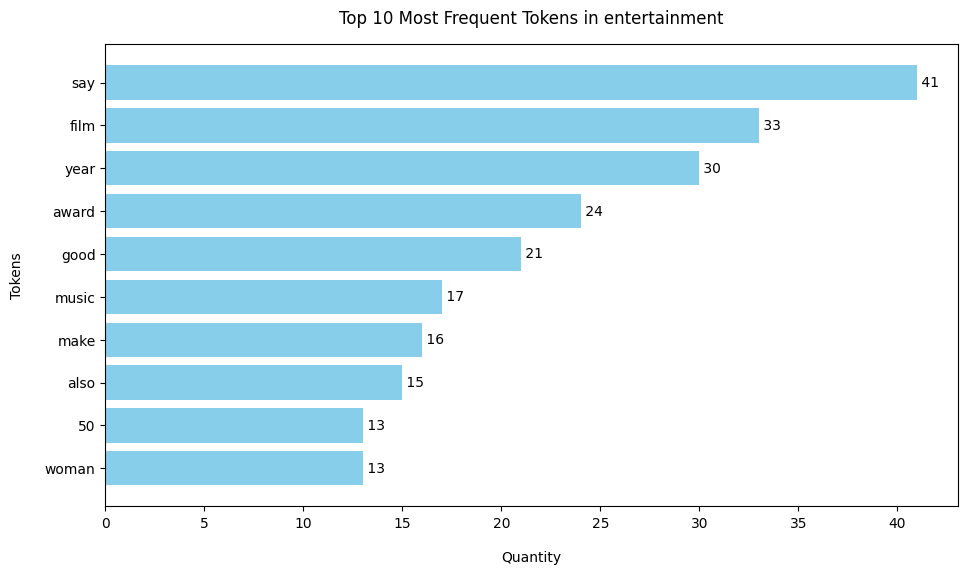

In [13]:
top_n = 10
fontsize = 12
title_entertainment = 'Top {} Most Frequent Tokens in entertainment'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'entertainment', title_entertainment, fontsize)
# common_words_entertainment = get_top_n_words(top_n, count_content['entertainment'])
# print(common_words_entertainment)

##Top 30 most frequent tokens in politics

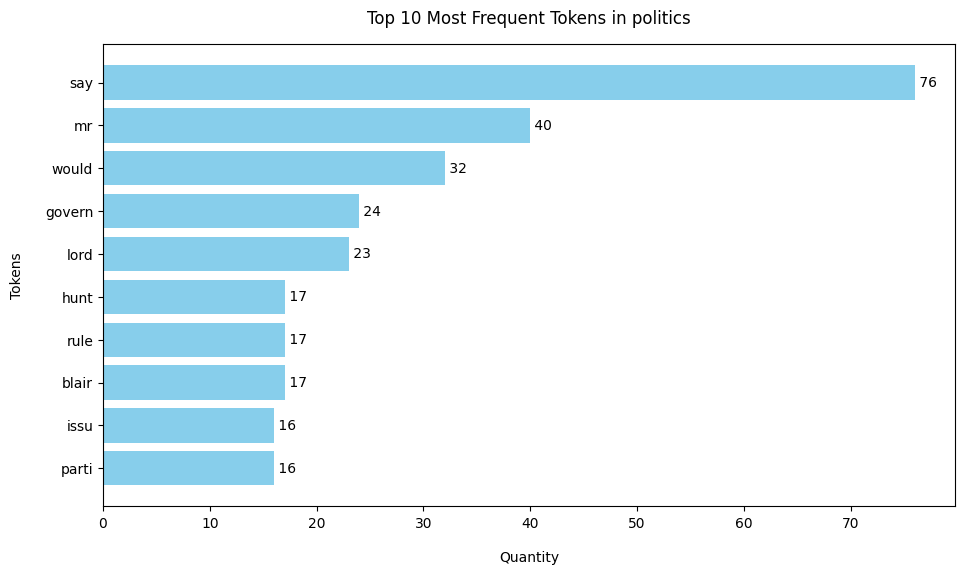

In [14]:
top_n = 10
fontsize = 12
title_politics = 'Top {} Most Frequent Tokens in politics'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'politics', title_politics, fontsize)
# common_words_politics = get_top_n_words(top_n, count_content['politics'])
# print(common_words_politics)

##Top 30 most frequent tokens in sport

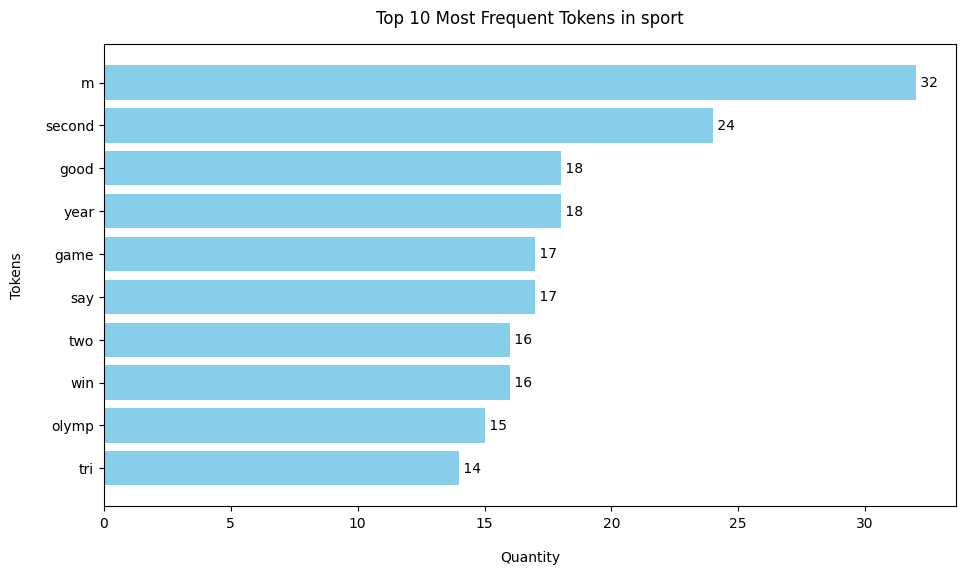

In [15]:
top_n = 10
fontsize = 12
title_sport = 'Top {} Most Frequent Tokens in sport'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'sport', title_sport, fontsize)
# common_words_sport = get_top_n_words(top_n, count_content['sport'])
# print(common_words_sport)

##Top 30 most frequent tokens in tech

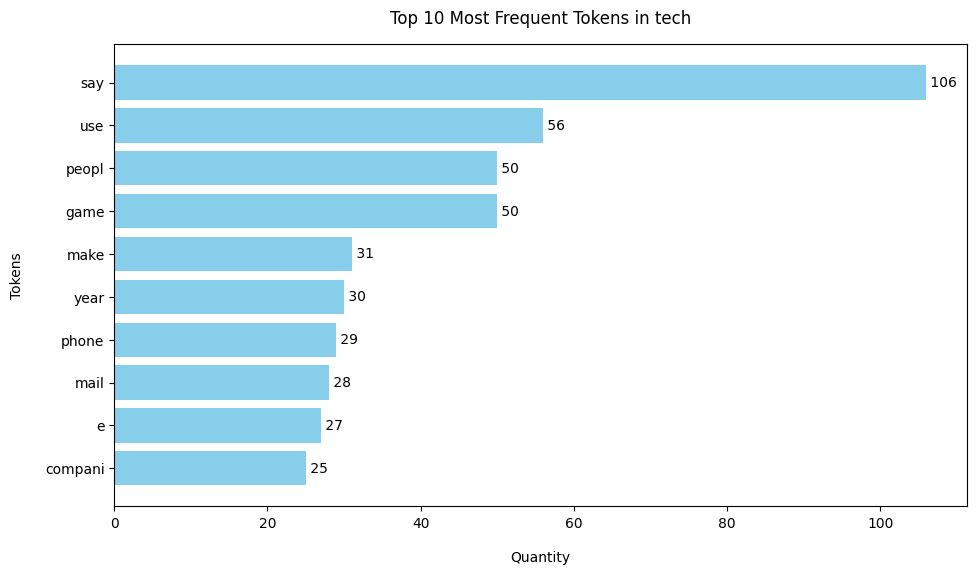

In [16]:
top_n = 10
fontsize = 12
title_tech = 'Top {} Most Frequent Tokens in tech'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'tech', title_tech, fontsize)
# common_words_tech = get_top_n_words(top_n, count_content['tech'])
# print(common_words_politics)

##Top 30 most frequent tokens in all dataset

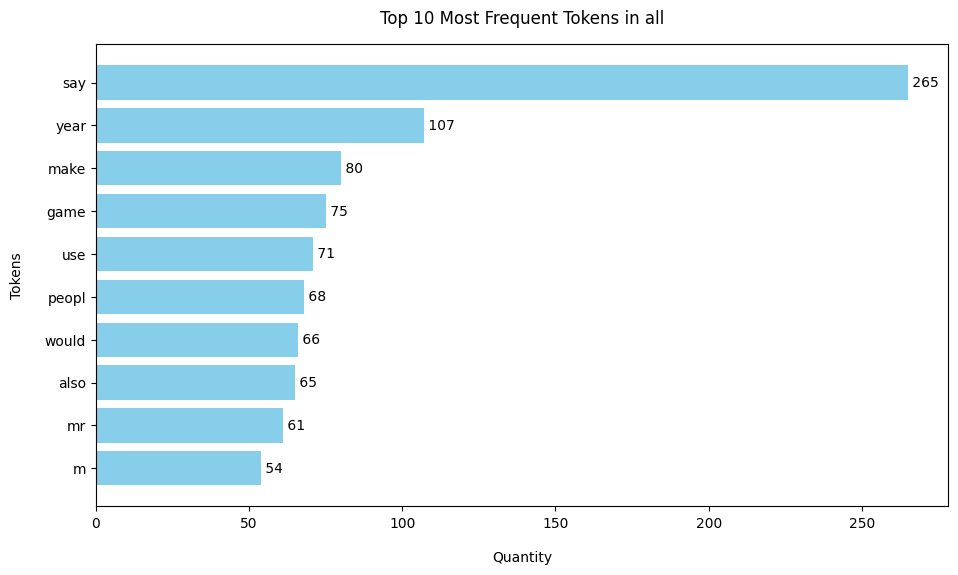

In [17]:
top_n = 10
fontsize = 12
title_all = 'Top {} Most Frequent Tokens in all'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'all', title_all, fontsize)
# common_words_all = get_top_n_words(top_n, count_content['all'])
# print(common_words_all)

#Frequency of class by word

In [18]:
import random

#Choose 10 random tokens in all content of news
random_words = random.sample(dict_content['all'].split(), 3)
print("random words: ", random_words)

def get_counts_by_genre(word, count_genres):
    counts_by_genre = {}  #Dictionary to store word count in each class
    for genre, content_counter in count_genres.items():
        if word in content_counter:
            counts_by_genre[genre] = content_counter[word]  # Adds the word count in the class to the dictionary
    return counts_by_genre


def get_frequency_class_by_word(selected_words, count_genres):
    dict_frequency = {}
    for word in selected_words:
        dict_frequency[word] = get_counts_by_genre(word, count_genres)
    return dict_frequency


dict_frequency = get_frequency_class_by_word(random_words, count_content)
print(dict_frequency)

random words:  ['across', 'find', 'make']
{'across': {'all': 6, 'entertainment': 2, 'tech': 4}, 'find': {'business': 2, 'all': 24, 'entertainment': 6, 'politics': 2, 'sport': 2, 'tech': 12}, 'make': {'business': 5, 'all': 80, 'entertainment': 16, 'politics': 14, 'sport': 14, 'tech': 31}}


In [19]:
#Testing
df[df['genre']=='politics']

,genre,filename,title,content
24,politics,1308.txt,Sainsbury's Labour election gift,scienc minist lord sainsburi make 2 m donat la...
25,politics,959.txt,Blair hails Turkey-EU talks deal,toni blair hail deal bring turkey step close e...
26,politics,1284.txt,EU rules 'won't stop UK spending',shape uk economi graphic deni rule british mem...
27,politics,1111.txt,Ministers 'naive' over phone-taps,govern naiv refus allow phone tap evid court s...
28,politics,922.txt,Butler launches attack on Blair,former civil servic chief lord butler criticis...
29,politics,966.txt,Visa decision 'every 11 minutes',visa process staff sometim expect rule applic ...
30,politics,1101.txt,Blair's hope for Blunkett return,event lead david blunkett resign must sweep ca...
31,politics,1064.txt,'No-one can define new hunt ban',new law ban hunt dog poorli draft one defin of...
32,politics,1229.txt,Immigration to be election issue,immigr asylum normal issu politician big parti...
33,politics,1075.txt,Falconer rebuts 'charade' claims,concess bill critic claim would allow euthanas...


# Frequency of words by documents

In [20]:
from collections import Counter

def get_frequency(df):
    frequency = {}
    for index, row in df.iterrows():
        filename = row['filename']
        word_counts = dict(Counter(row['content'].split()))
        if filename not in frequency:
          frequency[filename] = word_counts
    return frequency



frequency = get_frequency(df)
print(frequency)


{'138.txt': {'5': 2, '2': 1, 'million': 5, 'german': 4, 'work': 5, 'februari': 1, 'new': 2, 'figur': 5, 'show': 1, '216': 1, 'peopl': 5, '12': 1, '6': 1, 'age': 1, 'popul': 1, 'high': 2, 'jobless': 3, 'rate': 3, 'europ': 1, 'big': 1, 'economi': 1, 'sinc': 1, '1930': 1, 'news': 1, 'come': 2, 'head': 1, 'germani': 2, 'panel': 2, 'govern': 3, 'econom': 1, 'advis': 1, 'predict': 1, 'growth': 2, 'would': 2, 'stagnat': 1, 'speak': 1, 'tv': 1, 'bert': 1, 'ruerup': 1, 'say': 1, 'earli': 1, 'forecast': 1, '1': 2, '4': 2, 'optimist': 1, 'warn': 1, '2005': 1, 'tri': 1, 'tackl': 1, 'stubbornli': 1, 'level': 1, 'rang': 1, 'labour': 2, 'market': 1, 'reform': 1, 'centr': 1, 'hartz': 1, 'iv': 1, 'programm': 1, 'introduc': 1, 'januari': 3, 'shake': 1, 'welfar': 1, 'benefit': 1, 'push': 2, 'back': 1, 'even': 1, 'job': 2, 'heavili': 1, 'subsidis': 1, 'late': 1, 'unemploy': 5, 'look': 2, 'set': 1, 'increas': 1, 'pressur': 1, 'wide': 1, 'leak': 1, 'newspap': 1, 'day': 1, 'advanc': 1, 'produc': 1, 'scream':

In [21]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Word Index by documents





In [22]:
def create_word_index(df):
    h = {}
    for index, row in df.iterrows():
        filename = row['filename']
        content = row['content']
        words = content.split()
        for word in words:
            if word not in h:
                h[word] = {}

            if filename not in h[word]:
                h[word][filename] = 1
            else:
                h[word][filename] += 1
    return h

word_index = create_word_index(df)
print(word_index)

{'5': {'138.txt': 2, '65.txt': 2, '232.txt': 1, '257.txt': 1, '285.txt': 3, '860.txt': 1, '1308.txt': 1, '1381.txt': 2, '1863.txt': 1, '1993.txt': 1, '2099.txt': 1}, '2': {'138.txt': 1, '65.txt': 2, '181.txt': 2, '285.txt': 1, '511.txt': 1, '1308.txt': 2, '2144.txt': 1, '1993.txt': 2, '2112.txt': 2, '2164.txt': 1, '2099.txt': 2}, 'million': {'138.txt': 5, '232.txt': 1, '257.txt': 1, '607.txt': 1, '539.txt': 1, '2008.txt': 1, '1981.txt': 4, '2023.txt': 3, '1863.txt': 4, '1993.txt': 2, '2112.txt': 3, '2099.txt': 1, '2040.txt': 3}, 'german': {'138.txt': 4, '65.txt': 3, '232.txt': 1, '663.txt': 2, '778.txt': 1, '1506.txt': 1}, 'work': {'138.txt': 5, '257.txt': 1, '181.txt': 1, '860.txt': 3, '522.txt': 1, '511.txt': 1, '797.txt': 1, '641.txt': 1, '607.txt': 1, '679.txt': 1, '624.txt': 1, '875.txt': 1, '959.txt': 1, '1284.txt': 1, '1111.txt': 2, '1718.txt': 1, '1833.txt': 2, '2021.txt': 3, '2023.txt': 1, '2090.txt': 1, '2138.txt': 1, '2144.txt': 1, '2152.txt': 3, '1928.txt': 1, '2099.txt': 3

In [23]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Seach

## Pre processing in seach query

In [24]:
query = 'russian movie'
query = pre_processing_aux(query)
print(query)

russian movi


## Search query

In [25]:
def get_frequency_query(query, word_index):
    query_index = {}
    for word in query.split():
        if word in word_index:
            query_index[word] = word_index[word]
    return query_index


index_query = get_frequency_query(query, word_index)
print(index_query)


def sum_occurrences(index_query):
    f = {}
    for word_dict in index_query.values():
        for filename, count in word_dict.items():
            if filename not in f:
                f[filename] = count
            else:
                f[filename] += count

    return f

occurrences = sum_occurrences(index_query)
print(occurrences)

{'russian': {'1381.txt': 3}, 'movi': {'607.txt': 1, '2008.txt': 1, '2099.txt': 3}}
{'1381.txt': 3, '607.txt': 1, '2008.txt': 1, '2099.txt': 3}


In [26]:
def sort_sum_occurrences(occurrences):
  sorted_occurences = sorted(occurrences.items(), key=lambda x : x[1], reverse=True) #reverse is descr order
  return sorted_occurences


def get_top_n_docs(occurences, top_n):
  occurences = dict(occurences)
  docs = list(occurences.keys())[:top_n]
  return docs

sorted_occurences = sort_sum_occurrences(occurrences)
print(sorted_occurences)

top_n = 5
docs = get_top_n_docs(sorted_occurences, top_n)
print(docs)

[('1381.txt', 3), ('2099.txt', 3), ('607.txt', 1), ('2008.txt', 1)]
['1381.txt', '2099.txt', '607.txt', '2008.txt']


# Classifier

In [27]:
df.shape[0]

66

## Define test and training set

In [28]:
from sklearn.model_selection import train_test_split

def create_test_training_split(df, percent):
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []
    grouped = df.groupby('genre')

    for genre, group_df in grouped:

          X = group_df.drop('genre', axis='columns')
          y = group_df['genre']
          X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=percent, random_state=42)

          X_train_list.append(X_train)
          X_test_list.append(X_test)
          y_train_list.append(y_train)
          y_test_list.append(y_test)


    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    return X_train, y_train, X_test, y_test






percent_test = 0.2
X_df_train, y_train, X_df_test, y_test = create_test_training_split(df, percent_test)


In [29]:
X_df_train.head()
# X_df_train.shape[0]

,filename,title,content
0,138.txt,German jobless rate at new record,5 2 million german work februari new figur sho...
1,285.txt,China continues breakneck growth,china economi expand breakneck 9 5 2004 fast p...
2,232.txt,Bat spit drug firm goes to market,german firm whose main product deriv saliva va...
3,328.txt,House prices drop as sales slow,hous price fall novemb properti sale time leng...
4,121.txt,US bank in $515m SEC settlement,five bank america subsidiari agre pay total 51...


In [30]:
X_df_test.shape[0]

16

## Create dictionary for different words in training set

In [31]:
def create_unique_words(content):
  words = content.split()

  # dict_words é um dicionário que mapeia uma palavra em um índice
  # agua -> 0
  # casa -> 1
  # bola -> 2
  # ...
  dict_words = {}

  for word in words:
    if word not in dict_words:
      dict_words[word] = len(dict_words)

  return dict_words


content_train = X_df_train['content'].str.cat(sep=' ')
unique_words_set_train = create_unique_words(content_train)

print(unique_words_set_train)
print(f"len unique_words: {len(unique_words_set_train)}")

{'5': 0, '2': 1, 'million': 2, 'german': 3, 'work': 4, 'februari': 5, 'new': 6, 'figur': 7, 'show': 8, '216': 9, 'peopl': 10, '12': 11, '6': 12, 'age': 13, 'popul': 14, 'high': 15, 'jobless': 16, 'rate': 17, 'europ': 18, 'big': 19, 'economi': 20, 'sinc': 21, '1930': 22, 'news': 23, 'come': 24, 'head': 25, 'germani': 26, 'panel': 27, 'govern': 28, 'econom': 29, 'advis': 30, 'predict': 31, 'growth': 32, 'would': 33, 'stagnat': 34, 'speak': 35, 'tv': 36, 'bert': 37, 'ruerup': 38, 'say': 39, 'earli': 40, 'forecast': 41, '1': 42, '4': 43, 'optimist': 44, 'warn': 45, '2005': 46, 'tri': 47, 'tackl': 48, 'stubbornli': 49, 'level': 50, 'rang': 51, 'labour': 52, 'market': 53, 'reform': 54, 'centr': 55, 'hartz': 56, 'iv': 57, 'programm': 58, 'introduc': 59, 'januari': 60, 'shake': 61, 'welfar': 62, 'benefit': 63, 'push': 64, 'back': 65, 'even': 66, 'job': 67, 'heavili': 68, 'subsidis': 69, 'late': 70, 'unemploy': 71, 'look': 72, 'set': 73, 'increas': 74, 'pressur': 75, 'wide': 76, 'leak': 77, 'ne

## Tranform each doc in a vector

## Binary

In [32]:
import numpy as np

def create_binary_array_doc_aux(content, unique_words):
    tokens = content.split()
    binary_array = np.zeros((len(unique_words), ))
    for word in tokens:
        if word in unique_words:  # O(1)
            idx =  unique_words[word]
            binary_array[idx] = 1

    return binary_array


def create_binary_array_docs(df, unique_words):
    binary_words = []
    for index, row in df.iterrows():
        content = row['content']
        binary_array = create_binary_array_doc_aux(content, unique_words)
        binary_words.append(binary_array)

    return binary_words



#Each line represents a docs and its columns represents if there is the respective unique_word in the docs
binary_words_docs = create_binary_array_docs(X_df_train, unique_words_set_train)

print(binary_words_docs)
print(f"len of binary_words_docs: {len(binary_words_docs)}") # Must be igual to the number of docs

[array([1., 1., 1., ..., 0., 0., 0.]), array([1., 1., 0., ..., 0., 0., 0.]), array([1., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 

In [34]:
#################### Testing ###########################
def count_ones(vector):
  count = 0
  for element in vector:
    if element == 1:
      count += 1
  return count

num = '138.txt'
position = 0

print(f"Binary array of {num} file: { binary_words_docs[position].tolist() }")

# print len of binary_word_dict and unique_words_set_train. The size should be the same
print(f"Size of binary_word_vector of file {num} : {len(binary_words_docs[0])}")
print(f"Size of unique_words_set_train : {len(unique_words_set_train)}")

content_file = X_df_train[X_df_train['filename'] == num]['content'].values[0]
unique_words_file = create_unique_words(content_file)
print(f"Size of unique_words of file: {len(unique_words_file)}")

#The qtd of ones should be the same of unique_words file
num_ones = count_ones(binary_words_docs[position] )
print(f"Number of ones in the vector: {num_ones}")


Binary array of 138.txt file: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Frequency of word in docs

In [35]:
def create_word_frequency_aux(content, unique_words):
    tokens = content.split()

    # cria um array de zeros do tamanho do dicionario de palavras diferentes
    tamanho = (len(unique_words), ) # tupla com um elemento
    word_frequency = np.zeros(tamanho)

    for word in tokens: # para cada palavra no texto
        if word in unique_words:  # se a palavra existe no dicionario de palavras unicas
            idx =  unique_words[word] # recupera o indice da palavra
            word_frequency[idx] += 1 # incrementa a frequencia (vimos a palavra mais uma vez)

    return word_frequency


def create_word_frequency(df, unique_words):
  word_frequency = []
  for index, row in df.iterrows():
      content = row['content']
      word_frequency.append(create_word_frequency_aux(content, unique_words))

  return word_frequency

In [36]:
# Testing
word_frequency_file = create_word_frequency_aux(content_file, unique_words_set_train)
print(word_frequency_file.tolist())


[2.0, 1.0, 5.0, 4.0, 5.0, 1.0, 2.0, 5.0, 1.0, 1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [37]:
content_file

'5 2 million german work februari new figur show figur 5 216 million peopl 12 6 work age popul high jobless rate europ big economi sinc 1930 news come head germani panel govern econom advis predict growth would stagnat speak german tv bert ruerup say panel earli forecast 1 4 optimist warn growth would 1 2005 german govern tri tackl stubbornli high level jobless rang labour market reform centr hartz iv programm introduc januari shake welfar benefit push peopl back work even job heavili subsidis late unemploy figur look set increas pressur govern wide leak german newspap day advanc produc scream headlin criticis chancellor gerhard schroeder social democrat green parti administr mr schroeder origin come offic promis halv unemploy still measur suggest pictur quit bleak soar offici unemploy figur follow chang methodolog push jobless rate 500 000 januari adjust season chang overal unemploy rate 4 875 million peopl 11 7 0 3 percentag point previou month use intern accept methodolog intern lab

In [38]:
word_docs_frequency = create_word_frequency(X_df_train, unique_words_set_train)
print(word_docs_frequency)
print(f"len of word_frequency_file {len(word_docs_frequency)}")
print(f"unique_words in file: {create_unique_words(content_file)}")
print(f"len of unique words in file {(len(create_unique_words(content_file)))}")

[array([2., 1., 5., ..., 0., 0., 0.]), array([3., 1., 0., ..., 0., 0., 0.]), array([1., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 2., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 

## TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_aux(content, unique_words):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(unique_words)
    tfidf = tfidf_vectorizer.transform([content])
    return tfidf


# def create_tfidf(df, unique_words):
#     tfidf_vectorizer = TfidfVectorizer(min_df=0)
#     tfidf_matrix = []

#     for index, row in df.iterrows():
#         content = row['content']
#         tfidf_array = create_tfidf_aux([content], tfidf_vectorizer)
#         tfidf_matrix.append(tfidf_array[0])
#     return tfidf_matrix



# tf_idf_train = create_tfidf(train_df, unique_words_set_train)

tfidf_train = create_tfidf_aux(content_file, unique_words_set_train)

print("Len tfidf:", tfidf_train )

# train_docs = train_df['content']
# test_docs = test_df['content']

Len tfidf:   (0, 3045)	0.10355607461569961
  (0, 3037)	0.258890186539249
  (0, 3015)	0.05177803730784981
  (0, 2995)	0.05177803730784981
  (0, 2989)	0.05177803730784981
  (0, 2973)	0.05177803730784981
  (0, 2908)	0.05177803730784981
  (0, 2873)	0.258890186539249
  (0, 2854)	0.05177803730784981
  (0, 2832)	0.05177803730784981
  (0, 2723)	0.10355607461569961
  (0, 2720)	0.05177803730784981
  (0, 2675)	0.10355607461569961
  (0, 2664)	0.05177803730784981
  (0, 2655)	0.05177803730784981
  (0, 2629)	0.05177803730784981
  (0, 2602)	0.05177803730784981
  (0, 2571)	0.05177803730784981
  (0, 2547)	0.05177803730784981
  (0, 2540)	0.05177803730784981
  (0, 2539)	0.05177803730784981
  (0, 2516)	0.05177803730784981
  (0, 2500)	0.05177803730784981
  (0, 2477)	0.05177803730784981
  (0, 2469)	0.05177803730784981
  :	:
  (0, 406)	0.05177803730784981
  (0, 388)	0.05177803730784981
  (0, 381)	0.05177803730784981
  (0, 379)	0.05177803730784981
  (0, 351)	0.05177803730784981
  (0, 329)	0.05177803730784981
 

In [40]:
def calcule_tfidf(frequency_matrix):
  total_docs = len(frequency_matrix)
  document_frequency = np.count_nonzero(frequency_matrix, axis=0)
  idf = np.log(total_docs / (1 + document_frequency))
  tfidf = frequency_matrix * idf
  return tfidf


tfidf = calcule_tfidf(word_docs_frequency)
print(tfidf)
print(len(tfidf[2]))

[[3.93222571 1.71479843 7.57063866 ... 0.         0.         0.        ]
 [5.89833857 1.71479843 0.         ... 0.         0.         0.        ]
 [1.96611286 0.         1.51412773 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.71479843 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 3.21887582 3.21887582 3.21887582]]
3096


# Training classifiers

In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

print("labels train", y_train)
print("labels test", y_test)
# decoded_labels = label_encoder.inverse_transform(y_train)
# print("Rótulos Decodificados:", decoded_labels)

X_binary_train  = create_binary_array_docs(X_df_train, unique_words_set_train)
X_frequency_train = create_word_frequency(X_df_train, unique_words_set_train)
X_tfidf_train = calcule_tfidf(X_frequency_train)

X_train = [X_binary_train, X_frequency_train, X_tfidf_train ]

X_binary_test = create_binary_array_docs(X_df_test, unique_words_set_train)
X_frequency_test = create_word_frequency(X_df_test, unique_words_set_train)
X_tfidf_test = calcule_tfidf(X_frequency_test)

X_test = [X_binary_test , X_frequency_test , X_tfidf_test ]

labels train [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]
labels test [0 0 1 1 1 1 2 2 2 3 3 3 4 4 4 4]


In [58]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
]




for idx, (X_train_idx, X_test_idx) in enumerate(zip(X_train, X_test)):


  print(f'*************** Conjunto de teste {idx + 1} ****************************')
  for name, clf in zip(names, classifiers):
      clf.fit(X_train_idx, y_train)

      y_test_pred = clf.predict(X_test_idx)
      y_train_pred = clf.predict(X_train_idx)

      acc = accuracy_score(y_test, y_test_pred)
      print("-------------------- {} ----------------------".format(name))
      test_report = classification_report(y_test, y_test_pred, target_names=genres, zero_division=0)
      train_report = classification_report(y_train, y_train_pred, target_names=genres, zero_division=0)
      print('Train report')
      print(train_report)
      print('Test report')
      print(test_report)

      print("{}: Accuracy: {:.4%}".format(name, acc))
      conf_max = confusion_matrix(y_test, y_test_pred)
      print(f"Confusion Matrix:\n{conf_max}")


      # score = clf.score(X_test_idx, y_test)
      # print("{}: Score: {:.4%}".format(name, score))


  print("="*30)

*************** Conjunto de teste 1 ****************************
-------------------- Nearest Neighbors ----------------------
Train report
               precision    recall  f1-score   support

     business       0.29      0.33      0.31         6
entertainment       0.00      0.00      0.00        12
     politics       0.00      0.00      0.00         9
        sport       0.19      1.00      0.31         8
         tech       0.00      0.00      0.00        15

     accuracy                           0.20        50
    macro avg       0.09      0.27      0.12        50
 weighted avg       0.06      0.20      0.09        50

Test report
               precision    recall  f1-score   support

     business       0.00      0.00      0.00         2
entertainment       0.00      0.00      0.00         4
     politics       0.00      0.00      0.00         3
        sport       0.19      1.00      0.32         3
         tech       0.00      0.00      0.00         4

     accuracy     

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from matplotlib.colors import ListedColormap


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
]



def classification(X_train, X_test):
  for idx, (X_train_idx, X_test_idx) in enumerate(zip(X_train, X_test)):

    print(f'****Conjunto de teste {idx + 1}****')
    for name, clf in zip(names, classifiers):
        clf.fit(X_train_idx, y_train)

        train_predictions = clf.predict(X_test_idx)
        acc = accuracy_score(y_test, train_predictions)
        print("{}: Accuracy: {:.4%}".format(name, acc))

        # score = clf.score(X_test_idx, y_test)
        # print("{}: Score: {:.4%}".format(name, score))


    print("="*30)


classification(X_train, X_test)